In [85]:
import gymnasium as gym
import numpy as np
import pickle
from tqdm.notebook import trange
import matplotlib.pyplot as plt
from IPython import display
import time

In [86]:
env = gym.make('Taxi-v3', render_mode='rgb_array')

In [87]:
# initializing q-table
action_space_size = env.action_space.n
state_space_size = env.observation_space.n

q_table = np.zeros((state_space_size, action_space_size))

In [88]:
# hyperparameters
N_EPISODES = 1000
MAX_STEPS_PER_EPISODE = 200

N_STEPS = 4  # number of steps to sample from
ALPHA = 0.4  # learning rate
GAMMA = 1  # discount rate

EPSILON = 1  # exploration rate
EPSILON_MAX = 1
EPSILON_MIN = 0.1
EPSILON_DECAY = (2 * EPSILON) / N_EPISODES

LOG_RATE = N_EPISODES / 10

In [89]:
sum_rewards = 0

def select_action(state):
    if np.random.rand() > EPSILON:
        return np.argmax(q_table[state, :])
    else:
        return env.action_space.sample()

def state_value(state):
    return np.max(q_table[state, :])

for episode in trange(N_EPISODES):
    state, _ = env.reset()
    truncated = False

    action = select_action(state)
    states = [state]
    actions = [action]
    rewards = [0]

    tau = -N_STEPS + 1
    time_step = 0
    terminal_step = np.inf

    while tau < terminal_step:
        if time_step < terminal_step:
            new_state, reward, done, _, info = env.step(action)

            states.append(new_state)
            rewards.append(reward)

            sum_rewards += reward
            truncated = (not done) and (time_step >= MAX_STEPS_PER_EPISODE)

            if done or truncated:
                terminal_step = time_step + 1
            else:
                action = select_action(new_state)
                actions.append(action)
                state = new_state

        if tau >= 0:
            target = 0

            if time_step + 1 >= terminal_step:
                if truncated:
                    target = rewards[terminal_step] + \
                        GAMMA * state_value(terminal_step)
                else:
                    target = rewards[terminal_step]
            else:
                target = rewards[time_step + 1] + \
                    GAMMA * state_value(states[time_step + 1])

            for k in range(min(terminal_step - 1, time_step), tau, -1):
                if actions[k] == np.argmax(q_table[states[k], :]):
                    target = rewards[k] + GAMMA * target
                else:
                    target = rewards[k] + GAMMA * state_value(states[k])

            q_table[states[tau], actions[tau]] += ALPHA * \
                (target - q_table[states[tau], actions[tau]])

        time_step += 1
        tau += 1

    # updating epsilon
    EPSILON = max(EPSILON - EPSILON_DECAY, EPSILON_MIN)

    # logging the results
    if (episode + 1) % LOG_RATE == 0:
        print(f'Episode {episode + 1} : avg={sum_rewards / LOG_RATE}')
        sum_rewards = 0
        n_finished = 0
        sum_t = 0

# saving the q-table
with open('q_table.bin', 'wb') as f:
    pickle.dump(q_table, f)

  0%|          | 0/1000 [00:00<?, ?it/s]

Episode 100 : avg=-720.41
Episode 200 : avg=-425.4
Episode 300 : avg=-146.56
Episode 400 : avg=-17.49
Episode 500 : avg=-0.12
Episode 600 : avg=1.04
Episode 700 : avg=3.65
Episode 800 : avg=1.69
Episode 900 : avg=0.13
Episode 1000 : avg=3.62


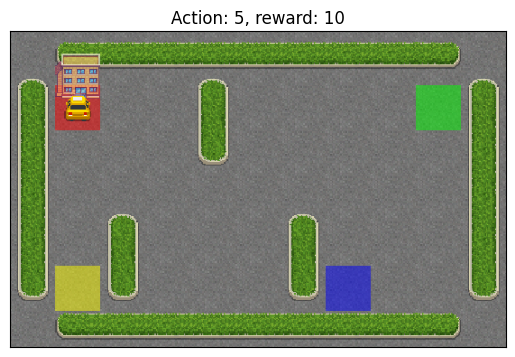

In [91]:
env = gym.make('Taxi-v3', render_mode='rgb_array')

# loading the q-table
with open('q_table.bin', 'rb') as f:
    q_table = pickle.load(f)

plt.tick_params(left=False, right=False, labelleft=False,
                labelbottom=False, bottom=False)

env.reset()
img = plt.imshow(env.render())

for episode in range(3):
    state, _ = env.reset()
    done = False
    sum_reward = 0

    plt.title(f"Episode #{episode + 1}")
    for step in range(MAX_STEPS_PER_EPISODE):
        action = np.argmax(q_table[state, :])  # greedy action selection

        new_state, reward, done, truncated, info = env.step(action)
        sum_reward += reward

        img.set_data(env.render())
        display.display(plt.gcf())
        display.clear_output(wait=True)
        plt.title(f'Action: {action}, reward: {sum_reward}')

        if done:
            display.display(plt.gcf())
            display.clear_output(wait=True)
            time.sleep(1)
            break

        state = new_state

env.close()